In [1]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Dataset

You can download dataset from here https://drive.google.com/drive/folders/1Q3RwG1TW82z6ZH1eZjUkQtFsXLpSZZkZ

In [2]:
train_path = 'Dataset/cat_dog/train'
validation_path = 'Dataset/cat_dog/valid'
test_path = 'Dataset/cat_dog/test'

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['cat', 'dog'], batch_size=16)
valid_batches = ImageDataGenerator().flow_from_directory(directory=validation_path, target_size=(224,224),
    classes=['cat', 'dog'], batch_size=16)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224),
    classes=['cat', 'dog'], batch_size=10)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

C:\Users\raiya\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


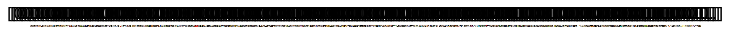

In [5]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

# Build Fine-tuned VGG16 model

In [6]:
vgg16_model = keras.applications.vgg16.VGG16()

In [7]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [10]:
for layer in model.layers:
    layer.trainable = False

In [11]:
model.add(Dense(2, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

# Train the fine-tuned VGG16 model

In [13]:
model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
h=model.fit_generator(generator=train_batches, steps_per_epoch=500, 
                    validation_data=valid_batches, validation_steps=125, epochs=10, verbose=2)

Epoch 1/10


# Loss

In [ ]:
epoch_nums = range(1, 11)
training_loss = h.history["loss"]
validation_loss = h.history["val_loss"]
plt.plot(epoch_nums , training_loss)
plt.plot(epoch_nums , validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.show()

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [ ]:
test_labels = test_labels[:,0]
test_labels

# Predict using Fine-tuned VGG16 model

In [ ]:
predictions = model.predict_generator(generator=test_batches, steps=1, verbose=0)

In [ ]:
predictions = np.array(predictions)
predictions = np.rint(predictions)
predictions

# Precision, Recall, F1_Score

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions[:,0]))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',):
    
    print('Confusion Matrix')
    print(cm)

    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=25)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(test_labels, predictions[:,0])
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')